<a href="https://colab.research.google.com/github/tushar-semwal/fedperf/blob/main/Santiago/Shakespeare/qFedAvg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FedPerf - Shakespeare + qFedAvg algorithm

## Setup & Dependencies Installation

In [1]:
%%capture
!pip install torchsummaryX unidecode

In [2]:
%load_ext tensorboard

import copy
from functools import reduce
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import Sampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torchsummaryX import summary as summaryx
from torchvision import transforms, utils, datasets
from tqdm.notebook import tqdm
from unidecode import unidecode

%matplotlib inline

# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
RANDOM_SEED = 42

# general reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Wed May  5 06:03:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    23W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Mount GDrive

In [3]:
BASE_DIR = '/content/drive/MyDrive/FedPerf/shakespeare/qFedAvg'

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.makedirs(BASE_DIR, exist_ok=True)
except:
    print("WARNING: Results won't be stored on GDrive")
    BASE_DIR = './'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Dataset

In [4]:
!rm -Rf data
!mkdir -p data scripts

In [5]:
GENERATE_DATASET = False  # If False, download the dataset provided by the q-FFL paper
DATA_DIR = 'data/'
# Dataset generation params
SAMPLES_FRACTION = 1.  # If using an already generated dataset
# SAMPLES_FRACTION = 0.2  # Fraction of total samples in the dataset - FedProx default script
# SAMPLES_FRACTION = 0.05  # Fraction of total samples in the dataset - qFFL
TRAIN_FRACTION = 0.8  # Train set size
MIN_SAMPLES = 0  # Min samples per client (for filtering purposes) - FedProx
# MIN_SAMPLES = 64  # Min samples per client (for filtering purposes) - qFFL

In [6]:
# Download raw dataset
# !wget https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt -O data/shakespeare.txt
!wget --adjust-extension http://www.gutenberg.org/files/100/100-0.txt -O data/shakespeare.txt

--2021-05-05 06:03:48--  http://www.gutenberg.org/files/100/100-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gutenberg.org/files/100/100-0.txt [following]
--2021-05-05 06:03:48--  https://www.gutenberg.org/files/100/100-0.txt
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5757108 (5.5M) [text/plain]
Saving to: ‘data/shakespeare.txt’

data/shakespeare.tx 100%[===================>]   5.49M  7.50MB/s    in 0.7s    

2021-05-05 06:03:50 (7.50 MB/s) - ‘data/shakespeare.txt’ saved [5757108/5757108]



In [7]:
if not GENERATE_DATASET:
    !rm -Rf data/train data/test
    !gdown --id 1n46Mftp3_ahRi1Z6jYhEriyLtdRDS1tD  # Download Shakespeare dataset used by the FedProx paper
    !unzip shakespeare.zip
    !mv -f shakespeare_paper/train data/
    !mv -f shakespeare_paper/test data/
    !rm -R shakespeare_paper/ shakespeare.zip


Downloading...
From: https://drive.google.com/uc?id=1n46Mftp3_ahRi1Z6jYhEriyLtdRDS1tD
To: /content/shakespeare.zip
2.96MB [00:00, 95.0MB/s]
Archive:  shakespeare.zip
   creating: shakespeare_paper/
   creating: shakespeare_paper/test/
  inflating: shakespeare_paper/test/all_data_niid_2_keep_0_test_8.json  
   creating: shakespeare_paper/train/
  inflating: shakespeare_paper/train/all_data_niid_2_keep_0_train_8.json  


In [8]:
corpus = []
with open('data/shakespeare.txt', 'r') as f:
    data = list(unidecode(f.read()))
    corpus = list(set(list(data)))
print('Corpus Length:', len(corpus))

Corpus Length: 90


#### Dataset Preprocessing script

In [9]:
%%capture
if GENERATE_DATASET:
    # Download dataset generation scripts
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/data/shakespeare/preprocess/preprocess_shakespeare.py -O scripts/preprocess_shakespeare.py
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/data/shakespeare/preprocess/shake_utils.py -O scripts/shake_utils.py
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/data/shakespeare/preprocess/gen_all_data.py -O scripts/gen_all_data.py

    # Download data preprocessing scripts
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/utils/sample.py -O scripts/sample.py
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/utils/remove_users.py -O scripts/remove_users.py

In [10]:
# Running scripts
if GENERATE_DATASET:
    !mkdir -p data/raw_data data/all_data data/train data/test
    !python scripts/preprocess_shakespeare.py data/shakespeare.txt data/raw_data
    !python scripts/gen_all_data.py

#### Dataset class

In [11]:
class ShakespeareDataset(Dataset):
    def __init__(self, x, y, corpus, seq_length):
        self.x = x
        self.y = y
        self.corpus = corpus
        self.corpus_size = len(self.corpus)
        super(ShakespeareDataset, self).__init__()

    def __len__(self):
        return len(self.x)

    def __repr__(self):
        return f'{self.__class__} - (length: {self.__len__()})'

    def __getitem__(self, i):
        input_seq = self.x[i]
        next_char = self.y[i]
        # print('\tgetitem', i, input_seq, next_char)
        input_value = self.text2charindxs(input_seq)
        target_value = self.get_label_from_char(next_char)
        return input_value, target_value

    def text2charindxs(self, text):
        tensor = torch.zeros(len(text), dtype=torch.int32)
        for i, c in enumerate(text):
            tensor[i] = self.get_label_from_char(c)
        return tensor

    def get_label_from_char(self, c):
        return self.corpus.index(c)

    def get_char_from_label(self, l):
        return self.corpus[l]

##### Federated Dataset

In [12]:
class ShakespeareFedDataset(ShakespeareDataset):
    def __init__(self, x, y, corpus, seq_length):
        super(ShakespeareFedDataset, self).__init__(x, y, corpus, seq_length)

    def dataloader(self, batch_size, shuffle=True):
        return DataLoader(self,
                          batch_size=batch_size,
                          shuffle=shuffle,
                          num_workers=0)


## Partitioning & Data Loaders

### IID

In [13]:
def iid_partition_(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [14]:
def iid_partition(corpus, seq_length=80, val_split=False):

    train_file = [os.path.join(DATA_DIR, 'train', f) for f in os.listdir(f'{DATA_DIR}/train') if f.endswith('.json')][0]
    test_file = [os.path.join(DATA_DIR, 'test', f) for f in os.listdir(f'{DATA_DIR}/test') if f.endswith('.json')][0]

    with open(train_file, 'r') as file:
        data_train = json.loads(unidecode(file.read()))

    with open(test_file, 'r') as file:
        data_test = json.loads(unidecode(file.read()))

    
    total_samples_train = sum(data_train['num_samples'])

    data_dict = {}

    x_train, y_train = [], []
    x_test, y_test = [], []
    # x_val, y_val = [], []

    users = list(zip(data_train['users'], data_train['num_samples']))
    # random.shuffle(users)



    total_samples = int(sum(data_train['num_samples']) * SAMPLES_FRACTION)
    print('Objective', total_samples, '/', sum(data_train['num_samples']))
    sample_count = 0
    
    for i, (author_id, samples) in enumerate(users):

        if sample_count >= total_samples:
            print('Max samples reached', sample_count, '/', total_samples)
            break

        if samples < MIN_SAMPLES: # or data_train['num_samples'][i] > 10000:
            print('SKIP', author_id, samples)
            continue
        else:
            udata_train = data_train['user_data'][author_id]
            max_samples = samples if (sample_count + samples) <= total_samples else (sample_count + samples - total_samples) 
            
            sample_count += max_samples
            # print('sample_count', sample_count)

            x_train.extend(data_train['user_data'][author_id]['x'][:max_samples])
            y_train.extend(data_train['user_data'][author_id]['y'][:max_samples])

            author_data = data_test['user_data'][author_id]
            test_size = int(len(author_data['x']) * SAMPLES_FRACTION)

            if val_split:
                x_test.extend(author_data['x'][:int(test_size / 2)])
                y_test.extend(author_data['y'][:int(test_size / 2)])
                # x_val.extend(author_data['x'][int(test_size / 2):])
                # y_val.extend(author_data['y'][int(test_size / 2):int(test_size)])

            else:
                x_test.extend(author_data['x'][:int(test_size)])
                y_test.extend(author_data['y'][:int(test_size)])

    train_ds = ShakespeareDataset(x_train, y_train, corpus, seq_length)
    test_ds = ShakespeareDataset(x_test, y_test, corpus, seq_length)
    # val_ds = ShakespeareDataset(x_val, y_val, corpus, seq_length)

    data_dict = iid_partition_(train_ds, clients=len(users))

    return train_ds, data_dict, test_ds

### Non-IID

In [15]:
def noniid_partition(corpus, seq_length=80, val_split=False):

    train_file = [os.path.join(DATA_DIR, 'train', f) for f in os.listdir(f'{DATA_DIR}/train') if f.endswith('.json')][0]
    test_file = [os.path.join(DATA_DIR, 'test', f) for f in os.listdir(f'{DATA_DIR}/test') if f.endswith('.json')][0]

    with open(train_file, 'r') as file:
        data_train = json.loads(unidecode(file.read()))

    with open(test_file, 'r') as file:
        data_test = json.loads(unidecode(file.read()))

    
    total_samples_train = sum(data_train['num_samples'])

    data_dict = {}

    x_test, y_test = [], []

    users = list(zip(data_train['users'], data_train['num_samples']))
    # random.shuffle(users)

    total_samples = int(sum(data_train['num_samples']) * SAMPLES_FRACTION)
    print('Objective', total_samples, '/', sum(data_train['num_samples']))
    sample_count = 0
    
    for i, (author_id, samples) in enumerate(users):

        if sample_count >= total_samples:
            print('Max samples reached', sample_count, '/', total_samples)
            break

        if samples < MIN_SAMPLES: # or data_train['num_samples'][i] > 10000:
            print('SKIP', author_id, samples)
            continue
        else:
            udata_train = data_train['user_data'][author_id]
            max_samples = samples if (sample_count + samples) <= total_samples else (sample_count + samples - total_samples) 
            
            sample_count += max_samples
            # print('sample_count', sample_count)

            x_train = data_train['user_data'][author_id]['x'][:max_samples]
            y_train = data_train['user_data'][author_id]['y'][:max_samples]

            train_ds = ShakespeareFedDataset(x_train, y_train, corpus, seq_length)

            x_val, y_val = None, None
            val_ds = None
            author_data = data_test['user_data'][author_id]
            test_size = int(len(author_data['x']) * SAMPLES_FRACTION)
            if val_split:
                x_test += author_data['x'][:int(test_size / 2)]
                y_test += author_data['y'][:int(test_size / 2)]
                x_val = author_data['x'][int(test_size / 2):]
                y_val = author_data['y'][int(test_size / 2):int(test_size)]

                val_ds = ShakespeareFedDataset(x_val, y_val, corpus, seq_length)

            else:
                x_test += author_data['x'][:int(test_size)]
                y_test += author_data['y'][:int(test_size)]

            data_dict[author_id] = {
                'train_ds': train_ds,
                'val_ds': val_ds
            }

    test_ds = ShakespeareFedDataset(x_test, y_test, corpus, seq_length)

    return data_dict, test_ds

## Models

### Shakespeare LSTM

In [16]:
class ShakespeareLSTM(nn.Module):
    """
    """

    def __init__(self, input_dim, embedding_dim, hidden_dim, classes, lstm_layers=2, dropout=0.1, batch_first=True):
        super(ShakespeareLSTM, self).__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.classes = classes
        self.no_layers = lstm_layers
        
        self.embedding = nn.Embedding(num_embeddings=self.classes,
                                      embedding_dim=self.embedding_dim)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, 
                            hidden_size=self.hidden_dim,
                            num_layers=self.no_layers,
                            batch_first=batch_first, 
                            dropout=dropout if self.no_layers > 1 else 0.)
        self.fc = nn.Linear(hidden_dim, self.classes)

    def forward(self, x, hc=None):
        batch_size = x.size(0)
        x_emb = self.embedding(x)
        out, (ht, ct) = self.lstm(x_emb.view(batch_size, -1, self.embedding_dim), hc)
        dense = self.fc(ht[-1])
        return dense
    
    def init_hidden(self, batch_size):
        return (Variable(torch.zeros(self.no_layers, batch_size, self.hidden_dim)),
                Variable(torch.zeros(self.no_layers, batch_size, self.hidden_dim)))


#### Model Summary

In [17]:
batch_size = 10
seq_length = 80 # mcmahan17a, fedprox, qFFL

shakespeare_lstm = ShakespeareLSTM(input_dim=seq_length,  
                                   embedding_dim=8,  # mcmahan17a, fedprox, qFFL
                                   hidden_dim=256,  # mcmahan17a, fedprox impl
                                #    hidden_dim=100,  # fedprox paper
                                   classes=len(corpus),
                                   lstm_layers=2,
                                   dropout=0.1,  # TODO:
                                   batch_first=True
                                   )

if torch.cuda.is_available():
  shakespeare_lstm.cuda()



hc = shakespeare_lstm.init_hidden(batch_size)

x_sample = torch.zeros((batch_size, seq_length),
                       dtype=torch.long,
                       device=(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')))

x_sample[0][0] = 1
x_sample

print("\nShakespeare LSTM SUMMARY")
print(summaryx(shakespeare_lstm, x_sample))


Shakespeare LSTM SUMMARY
            Kernel Shape   Output Shape  Params  Mult-Adds
Layer                                                     
0_embedding      [8, 90]    [10, 80, 8]     720        720
1_lstm                 -  [10, 80, 256]  798720     794624
2_fc           [256, 90]       [10, 90]   23130      23040
----------------------------------------------------------
                      Totals
Total params          822570
Trainable params      822570
Non-trainable params       0
Mult-Adds             818384
            Kernel Shape   Output Shape  Params  Mult-Adds
Layer                                                     
0_embedding      [8, 90]    [10, 80, 8]     720        720
1_lstm                 -  [10, 80, 256]  798720     794624
2_fc           [256, 90]       [10, 90]   23130      23040


## qFedAvg Algorithm

### Plot Utils

In [18]:
from sklearn.metrics import f1_score

In [19]:
def plot_scores(history, exp_id, title, suffix):
    accuracies = [x['accuracy'] for x in history]
    f1_macro = [x['f1_macro'] for x in history]
    f1_weighted = [x['f1_weighted'] for x in history]

    fig, ax = plt.subplots()
    ax.plot(accuracies, 'tab:orange')
    ax.set(xlabel='Rounds', ylabel='Test Accuracy', title=title)
    ax.grid()
    fig.savefig(f'{BASE_DIR}/{exp_id}/Test_Accuracy_{suffix}.jpg', format='jpg', dpi=300)
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(f1_macro, 'tab:orange')
    ax.set(xlabel='Rounds', ylabel='Test F1 (macro)', title=title)
    ax.grid()
    fig.savefig(f'{BASE_DIR}/{exp_id}/Test_F1_Macro_{suffix}.jpg', format='jpg')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(f1_weighted, 'tab:orange')
    ax.set(xlabel='Rounds', ylabel='Test F1 (weighted)', title=title)
    ax.grid()
    fig.savefig(f'{BASE_DIR}/{exp_id}/Test_F1_Weighted_{suffix}.jpg', format='jpg')
    plt.show()


def plot_losses(history, exp_id, title, suffix):
    val_losses = [x['loss'] for x in history]
    train_losses = [x['train_loss'] for x in history]

    fig, ax = plt.subplots()
    ax.plot(train_losses, 'tab:orange')
    ax.set(xlabel='Rounds', ylabel='Train Loss', title=title)
    ax.grid()
    fig.savefig(f'{BASE_DIR}/{exp_id}/Train_Loss_{suffix}.jpg', format='jpg')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(val_losses, 'tab:orange')
    ax.set(xlabel='Rounds', ylabel='Test Loss', title=title)
    ax.grid()
    fig.savefig(f'{BASE_DIR}/{exp_id}/Test_Loss_{suffix}.jpg', format='jpg')
    plt.show()


### Local Training (Client Update)

In [20]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      data, label = self.dataset[self.idxs[item]]
      return data, label

In [21]:
class ClientUpdate(object):
  def __init__(self, dataset, batch_size, learning_rate, epochs, idxs, q=None):
    """

    """
    if hasattr(dataset, 'dataloader'):
        self.train_loader = dataset.dataloader(batch_size=batch_size, shuffle=True)
    else:
        self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batch_size, shuffle=True)

    self.learning_rate = learning_rate
    self.epochs = epochs
    self.q = q
    if not self.q:
        # TODO: Client itself adjust fairness 
        pass
    self.mu = 1e-10

  def train(self, model):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
    # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

    e_loss = []
    model_weights = copy.deepcopy(model.state_dict())
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      # for data, labels in tqdm(self.train_loader):
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        # print('input', data.size())
        output = model(data)
        # print('output', output.size())
        # print('labels', labels.size())
        # calculate the loss
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)


    total_loss = sum(e_loss)/len(e_loss)

    # delta weights
    model_weights_new = copy.deepcopy(model.state_dict())
    L = 1.0 / self.learning_rate

    delta_weights, delta, h = {}, {}, {}
    loss_q = np.float_power(total_loss + self.mu, self.q)
    # updating the global weights
    for k in model_weights_new.keys():
      delta_weights[k] = (model_weights[k] - model_weights_new[k]) * L
      delta[k] =  loss_q * delta_weights[k]
      # Estimation of the local Lipchitz constant
      h[k] = (self.q * np.float_power(total_loss + self.mu, self.q - 1) * torch.pow(torch.norm(delta_weights[k]), 2)) + (L * loss_q)

    return delta, h, total_loss

### Server Side Training

In [22]:
def client_sampling(n, m, weights=None, with_replace=False):
    pk = None
    if weights:
        total_weights = np.sum(np.asarray(weights))
        pk = [w * 1.0 / total_weights for w in weights]

    return np.random.choice(range(n), m, replace=with_replace, p=pk)

In [23]:
def training(model, rounds, batch_size, lr, ds, data_dict, test_ds, C, K, E, q=0, sampling='uniform', tb_logger=None, test_history=[], perf_fig_file='loss.jpg', M=0.1):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - test_ds          Dataset used for global testing
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - q:               Parameter that tunes the amount of fairness we wish to impose (default: 0 -> vanilla FedAvg objective)
    - sampling         Uniform or weighted (default: uniform)
    - tb_logger:       Tensorboard SummaryWriter
    - test_history:    Test Scores history log
    - perf_fig_file    File for storing final performance plot (loss)
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss = []

  # client weights by total samples
  p_k = None
  if sampling == 'weighted':
    p_k = [len(data_dict[c]) for c in data_dict] if ds else [len(data_dict[c]['train_ds']) for c in data_dict]

  # Time log
  start_time = time.time()

  users_id = list(data_dict.keys())

  # Orchestrate training
  for curr_round in range(1, rounds+1):
    deltas, hs, local_loss = [], [], []

    m = max(int(C*K), 1)    
    S_t = client_sampling(K, m, weights=p_k, with_replace=False)

    print('Round: {} Picking {}/{} clients: {}'.format(curr_round, m, K, S_t))
    c = 0
    global_weights = model.state_dict()

    for k in tqdm(S_t):
      key = users_id[k]
      ds_ = ds if ds else data_dict[key]['train_ds']
      idxs = data_dict[key] if ds else None
      # print(f'Client {k}: {len(idxs) if idxs else len(ds_)} samples')
      local_update = ClientUpdate(dataset=ds_, batch_size=batch_size, learning_rate=lr, epochs=E, idxs=idxs, q=q)
    #   weights, loss = local_update.train(model=copy.deepcopy(model))
      
      delta_k, h_k, loss = local_update.train(model=copy.deepcopy(model))

      if c < int(m*M):
        for k in global_weights.keys():
          d = torch.Tensor(delta_k[k].shape).cuda()
          h = torch.Tensor(h_k[k].shape).cuda()
          #l = torch.Tensor(loss[k].shape).cuda()
          d.fill_(1)
          h.fill_(1)
          #l.fill_(0.1)
          delta_k[k] = d
          h_k[k] = h
          #loss[k] = l

      deltas.append(copy.deepcopy(delta_k))
      hs.append(copy.deepcopy(h_k))
      local_loss.append(copy.deepcopy(loss))

      c += 1

      if tb_logger:
        tb_logger.add_scalar(f'Round/S{k}', loss, curr_round)

    # Perform qFedAvg
    #print(hs, deltas)
    h_sum = copy.deepcopy(hs[0])
    delta_sum = copy.deepcopy(deltas[0])
    
    for k in h_sum.keys():
        for i in range(1, len(hs)):
            h_sum[k] += hs[i][k]
            delta_sum[k] += deltas[i][k]

    new_weights = {}
    for k in delta_sum.keys():
        for i in range(len(deltas)):
            new_weights[k] = delta_sum[k] / h_sum[k]

    # Updating global model weights
    for k in global_weights.keys():
        global_weights[k] -= new_weights[k]

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)

    if tb_logger:
        tb_logger.add_scalar('Train/Loss', loss_avg, curr_round)
        # tb_logger.add_scalar(f'Train/Datapoints', total_datapoints, curr_round)
    
    # if curr_round % eval_every == 0:
    test_scores = testing(model, test_ds, batch_size, nn.CrossEntropyLoss(), num_classes, list(range(num_classes)))
    test_scores['train_loss'] = loss_avg
    test_history.append(test_scores)
    if tb_logger:
        tb_logger.add_scalar(f'Test/Loss', test_scores['loss'], curr_round)
        tb_logger.add_scalars(f'Test/Scores', {
            'accuracy': test_scores['accuracy'], 'f1_macro': test_scores['f1_macro'], 'f1_weighted': test_scores['f1_weighted']
        }, curr_round)
  
  end_time = time.time()
  
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis, 'tab:orange')

  ax.set(xlabel='# Rounds', ylabel='Train Loss',
       title="Model's Performance with q: {}".format(q))
  ax.grid()
  #fig.savefig(perf_fig_file, format='jpg')

  print("Training Done! Total time: {}".format(round(end_time - start_time, 3)))
  return model, test_history

### Testing Loop

In [24]:
def testing(model, dataset, bs, criterion, num_classes, classes, print_all=False):
  #test loss 
  test_loss = 0.0
  y_true, y_hat = None, None

  correct_class = list(0 for i in range(num_classes))
  total_class = list(0 for i in range(num_classes))

  if hasattr(dataset, 'dataloader'):
    test_loader = dataset.dataloader(batch_size=bs, shuffle=False)
  else:
    test_loader = DataLoader(dataset, batch_size=bs, shuffle=False)

  l = len(test_loader)

  model.eval()
  for i, (data, labels) in enumerate(tqdm(test_loader)):

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, dim=1)

    # For F1Score
    y_true = np.append(y_true, labels.data.view_as(pred).cpu().numpy()) if i != 0 else labels.data.view_as(pred).cpu().numpy()
    y_hat = np.append(y_hat, pred.cpu().numpy()) if i != 0 else pred.cpu().numpy()

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    # for i in range(num_classes):
    #   label = labels.data[i]
    #   correct_class[label] += correct[i].item()
    #   total_class[label] += 1

    for i, lbl in enumerate(labels.data):
      try:
        # print(type(lbl))
        # correct_class[lbl.data[0]] += correct.data[i]
        correct_class[lbl.item()] += correct[i]
        total_class[lbl.item()] += 1
      except:
          print('Error', lbl, i)
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  print("Test Loss: {:.6f}\n".format(test_loss))

  # Avg F1 Score
  f1_macro = f1_score(y_true, y_hat, average='macro')
  # F1-Score -> weigthed to consider class imbalance
  f1_weighted =  f1_score(y_true, y_hat, average='weighted')
  print("F1 Score: {:.6f} (macro) {:.6f} (weighted) %\n".format(f1_macro, f1_weighted))

  # print test accuracy
  if print_all:
    for i in range(num_classes):
        if total_class[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
                    (classes[i], 100 * correct_class[i] / total_class[i],
                    np.sum(correct_class[i]), np.sum(total_class[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  overall_accuracy = np.sum(correct_class) / np.sum(total_class)

  print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(overall_accuracy, np.sum(correct_class), np.sum(total_class)))

  return {'loss': test_loss, 'accuracy': overall_accuracy, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted}

## Experiments

In [25]:
# FAIL-ON-PURPOSE

In [26]:
seq_length = 80  # mcmahan17a, fedprox, qFFL
embedding_dim = 8  # mcmahan17a, fedprox, qFFL
# hidden_dim = 100  # fedprox paper
hidden_dim = 256  # mcmahan17a, fedprox impl
num_classes = len(corpus)
classes = list(range(num_classes))
lstm_layers = 2  # mcmahan17a, fedprox, qFFL
dropout = 0.1  # TODO

In [27]:
class Hyperparameters():

    def __init__(self, total_clients):
        # number of training rounds
        self.rounds = 10
        # client fraction
        self.C = 0.07
        # number of clients
        self.K = total_clients
        # number of training passes on local dataset for each roung
        self.E = 5  # qFFL
        # batch size
        self.batch_size = 10  # fedprox
        # learning Rate
        self.lr = 0.8  # fedprox, qFFL
        # fairness
        self.q = 0.001  # qFFL
        # sampling
        # self.sampling = 'uniform'
        self.sampling = 'weighted'

In [28]:
exp_log = dict()

### IID

In [29]:
train_ds, data_dict, test_ds = iid_partition(corpus, seq_length, val_split=True)

total_clients = len(data_dict.keys())
'Total users:', total_clients

Objective 413629 / 413629


('Total users:', 143)

In [30]:
hparams = Hyperparameters(total_clients)
hparams.__dict__

{'C': 0.07,
 'E': 5,
 'K': 143,
 'batch_size': 10,
 'lr': 0.8,
 'q': 0.001,
 'rounds': 10,
 'sampling': 'weighted'}

In [31]:
# Sweeping parameter
PARAM_NAME = 'clients_fraction'
PARAM_VALUE = hparams.C
exp_id = f'{PARAM_NAME}/{PARAM_VALUE}'
exp_id

'clients_fraction/0.07'

In [32]:
EXP_DIR = f'{BASE_DIR}/{exp_id}'
os.makedirs(EXP_DIR, exist_ok=True)

# tb_logger = SummaryWriter(log_dir)
# print(f'TBoard logger created at: {log_dir}')

title = 'LSTM qFedAvg on IID'

In [33]:
def run_experiment(run_id):

    shakespeare_lstm = ShakespeareLSTM(input_dim=seq_length,  
                                   embedding_dim=embedding_dim,  
                                   hidden_dim=hidden_dim,
                                   classes=num_classes,
                                   lstm_layers=lstm_layers,
                                   dropout=dropout,
                                   batch_first=True
                                   )

    if torch.cuda.is_available():
        shakespeare_lstm.cuda()
    
    test_history = []

    lstm_iid_trained, test_history = training(shakespeare_lstm,
                                              hparams.rounds, hparams.batch_size, hparams.lr,
                                              train_ds, data_dict, test_ds,
                                              hparams.C, hparams.K, hparams.E, hparams.q,
                                              sampling=hparams.sampling,
                                              test_history=test_history,
                                              # tb_logger=tb_logger,
                                              # perf_fig_file=f'{BASE_DIR}/loss.jpg'
                                              )
    
    final_scores = testing(lstm_iid_trained, test_ds, batch_size * 2, nn.CrossEntropyLoss(), len(corpus), corpus)
    print(f'\n\n========================================================\n\n')
    print(f'Final scores for Exp {run_id} \n {final_scores}')

    log = {
        'history': test_history,
        'hyperparams': hparams.__dict__
    }

    with open(f'{EXP_DIR}/stragg0.5_results_iid_{run_id}.pkl', 'wb') as file:
        pickle.dump(log, file)

    return test_history

In [ ]:
exp_history = list()
for run_id in range(1):  # TOTAL RUNS
    print(f'============== RUNNING EXPERIMENT #{run_id} ==============')
    exp_history.append(run_experiment(run_id))
    print(f'\n\n========================================================\n\n')

============== RUNNING EXPERIMENT #0 ==============
Round: 1 Picking 10/143 clients: [105  96  43  35  56  26  54 142  31  30]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:662: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  self.dropout, self.training, self.bidirectional, self.batch_first)



Round: 1... 	Average Loss: 2.719



Test Loss: 3.109909

F1 Score: 0.014568 (macro) 0.101177 (weighted) %


Final Test  Accuracy: 0.147 (7589/51704)
Round: 2 Picking 10/143 clients: [ 25 131   3  16  92  59  44  57  66  55]



Round: 2... 	Average Loss: 2.812



Test Loss: 3.677652

F1 Score: 0.012286 (macro) 0.092216 (weighted) %


Final Test  Accuracy: 0.164 (8485/51704)
Round: 3 Picking 10/143 clients: [ 10 113  11  91  71 121  17  99  23 136]



Round: 3... 	Average Loss: 3.094



Test Loss: 3.694293

F1 Score: 0.009683 (macro) 0.077402 (weighted) %


Final Test  Accuracy: 0.148 (7661/51704)
Round: 4 Picking 10/143 clients: [104 139  77  84 128 105  65  52  73 100]



Round: 4... 	Average Loss: 3.727



Test Loss: 3.876417

F1 Score: 0.009534 (macro) 0.077436 (weighted) %


Final Test  Accuracy: 0.196 (10121/51704)
Round: 5 Picking 10/143 clients: [ 54  60  45  87  25  67 137   3 129   1]


In [ ]:
exp_log[title] = {
    'history': exp_history,
    'hyperparams': hparams.__dict__
}

In [ ]:
df = None
for i, e in enumerate(exp_history):
    if i == 0:
        df = pd.json_normalize(e)
        continue
    df = df + pd.json_normalize(e)
    
df_avg = df / len(exp_history)
avg_history = df_avg.to_dict(orient='records')

In [ ]:
plot_scores(history=avg_history, exp_id=exp_id, title=title, suffix='IID')

In [ ]:
plot_losses(history=avg_history, exp_id=exp_id, title=title, suffix='IID')

In [ ]:
#with open(f'{EXP_DIR}/results_iid.pkl', 'wb') as file:
#    pickle.dump(exp_log, file)

### Non-IID

In [37]:
exp_log = dict()

In [38]:
data_dict, test_ds = noniid_partition(corpus, seq_length=seq_length, val_split=True)

total_clients = len(data_dict.keys())
'Total users:', total_clients

Objective 413629 / 413629


('Total users:', 143)

In [39]:
hparams = Hyperparameters(total_clients)
hparams.__dict__

{'C': 0.07,
 'E': 5,
 'K': 143,
 'batch_size': 10,
 'lr': 0.8,
 'q': 0.001,
 'rounds': 10,
 'sampling': 'weighted'}

In [40]:
# Sweeping parameter
PARAM_NAME = 'clients_fraction'
PARAM_VALUE = hparams.C
exp_id = f'{PARAM_NAME}/{PARAM_VALUE}'
exp_id

'clients_fraction/0.07'

In [41]:
EXP_DIR = f'{BASE_DIR}/{exp_id}'
os.makedirs(EXP_DIR, exist_ok=True)

# tb_logger = SummaryWriter(log_dir)
# print(f'TBoard logger created at: {log_dir}')

title = 'LSTM qFedAvg on Non-IID'

In [42]:
def run_experiment(run_id):
    shakespeare_lstm = ShakespeareLSTM(input_dim=seq_length,
                                       embedding_dim=embedding_dim,
                                       hidden_dim=hidden_dim,
                                       classes=num_classes,
                                       lstm_layers=lstm_layers,
                                       dropout=dropout,
                                       batch_first=True
                                       )

    if torch.cuda.is_available():
        shakespeare_lstm.cuda()

    test_history = []

    lstm_noniid_trained, test_history = training(shakespeare_lstm,
                                             hparams.rounds, hparams.batch_size, hparams.lr,
                                             None, data_dict, test_ds,
                                             hparams.C, hparams.K, hparams.E, hparams.q,
                                             sampling=hparams.sampling,
                                             test_history=test_history,
                                             # tb_logger=tb_logger,
                                             # perf_fig_file=f'{BASE_DIR}/loss.jpg'
                                             )
    
    final_scores = testing(lstm_noniid_trained, test_ds, batch_size * 2, nn.CrossEntropyLoss(), len(corpus), corpus)
    print(f'\n\n========================================================\n\n')
    print(f'Final scores for Exp {run_id} \n {final_scores}')

    log = {
        'history': test_history,
        'hyperparams': hparams.__dict__
    }

    with open(f'{EXP_DIR}/stragg0.5_results_niid_{run_id}.pkl', 'wb') as file:
        pickle.dump(log, file)

    return test_history

============== RUNNING EXPERIMENT #0 ==============
Round: 1 Picking 10/143 clients: [133 106  12  39  85 119  93  73 112 140]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:662: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  self.dropout, self.training, self.bidirectional, self.batch_first)



Round: 1... 	Average Loss: 2.353



Test Loss: 2.970050

F1 Score: 0.017714 (macro) 0.136817 (weighted) %


Final Test  Accuracy: 0.255 (13182/51704)
Round: 2 Picking 10/143 clients: [101  93 141  18  85  44   4  73  69 119]



Round: 2... 	Average Loss: 2.055



Test Loss: 2.476131

F1 Score: 0.051227 (macro) 0.256735 (weighted) %


Final Test  Accuracy: 0.336 (17348/51704)
Round: 3 Picking 10/143 clients: [ 44 140  45  85  39 108  16  73  14  77]



Round: 3... 	Average Loss: 1.838



Test Loss: 2.223465

F1 Score: 0.079017 (macro) 0.322349 (weighted) %


Final Test  Accuracy: 0.388 (20051/51704)
Round: 4 Picking 10/143 clients: [129 101 112  18  48  77  16   7   4 141]



Round: 4... 	Average Loss: 1.685



Test Loss: 2.119484

F1 Score: 0.100553 (macro) 0.356757 (weighted) %


Final Test  Accuracy: 0.414 (21416/51704)
Round: 5 Picking 10/143 clients: [ 58  66  18  85 141 108  45  68   2  95]



Round: 5... 	Average Loss: 1.585



Test Loss: 2.022779

F1 Score: 0.120990 (macro) 0.386884 (weighted) %


Final Test  Accuracy: 0.432 (22346/51704)
Round: 6 Picking 10/143 clients: [108 141 112  48  40  95 106 119  93  11]



Round: 6... 	Average Loss: 1.584



Test Loss: 1.959611

F1 Score: 0.131495 (macro) 0.393377 (weighted) %


Final Test  Accuracy: 0.440 (22756/51704)
Round: 7 Picking 10/143 clients: [ 69   4 110  16  66  58  76  49  93 140]



Round: 7... 	Average Loss: 1.488



Test Loss: 1.935598

F1 Score: 0.139926 (macro) 0.402374 (weighted) %


Final Test  Accuracy: 0.448 (23169/51704)
Round: 8 Picking 10/143 clients: [  6 142 120  92  18  69 122  84 112  93]



Round: 8... 	Average Loss: 1.466



Test Loss: 1.891919

F1 Score: 0.150178 (macro) 0.411063 (weighted) %


Final Test  Accuracy: 0.455 (23508/51704)
Round: 9 Picking 10/143 clients: [108  48  85  27  66 112 141   6  26  16]



Round: 9... 	Average Loss: 1.549



Test Loss: 1.928075

F1 Score: 0.147334 (macro) 0.405086 (weighted) %


Final Test  Accuracy: 0.449 (23239/51704)
Round: 10 Picking 10/143 clients: [140 108  84  18 112  64  69  93  16  75]



Round: 10... 	Average Loss: 1.477



Test Loss: 1.851654

F1 Score: 0.163736 (macro) 0.422602 (weighted) %


Final Test  Accuracy: 0.463 (23945/51704)
Training Done! Total time: 6743.97



Test Loss: 1.851654

F1 Score: 0.163736 (macro) 0.422602 (weighted) %


Final Test  Accuracy: 0.463 (23945/51704)




Final scores for Exp 0 
 {'loss': 1.851654386500327, 'accuracy': 0.4631169735416989, 'f1_macro': 0.16373620878950446, 'f1_weighted': 0.4226022484308912}






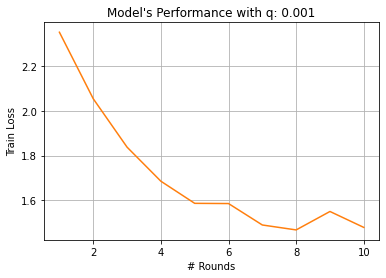

In [43]:
exp_history = list()
for run_id in range(1):  # TOTAL RUNS
    print(f'============== RUNNING EXPERIMENT #{run_id} ==============')
    exp_history.append(run_experiment(run_id))
    print(f'\n\n========================================================\n\n')

In [ ]:
exp_log[title] = {
    'history': exp_history,
    'hyperparams': hparams.__dict__
}

In [ ]:
df = None
for i, e in enumerate(exp_history):
    if i == 0:
        df = pd.json_normalize(e)
        continue
    df = df + pd.json_normalize(e)
    
df_avg = df / len(exp_history)
avg_history = df_avg.to_dict(orient='records')

In [ ]:
plot_scores(history=avg_history, exp_id=exp_id, title=title, suffix='nonIID')

In [ ]:
plot_losses(history=avg_history, exp_id=exp_id, title=title, suffix='nonIID')

### Pickle Experiment Results

In [ ]:
with open(f'{EXP_DIR}/Shakespeare_qFFL_stragglers0_5.pkl', 'wb') as file:
    pickle.dump(exp_log, file)